# Thrombin results analysis with the Legacy code for TS
Shows the use case of two different TS methods-Standard and Enhanced Thompson Sampling

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
import os
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
import polars as pl
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json
import copy

# Setup paths for importing from TACTICS
tactics_root = Path.cwd().parent
sys.path.insert(0, str(tactics_root))
from TACTICS.thompson_sampling.config import StandardSamplerConfig
from TACTICS.thompson_sampling.legacy.ts_main import *
from TACTICS.library_analysis.library_analysis_utils import compile_product_scores, compile_product_smiles

print("✓ Imports successful!")
print(f"✓ TACTICS root: {tactics_root}")

✓ Imports successful!
✓ TACTICS root: /Users/aakankschitnandkeolyar/Desktop/TACTICS


## Start with Standard TS
Uses Greedy selection criteria and is sequential (1 molecule at a time)

In [72]:
input_json_file = """{
    "sampler_type": "standard",
    "ts_mode": "minimize",
    "reagent_file_list": [
        "/Users/aakankschitnandkeolyar/Desktop/TACTICS/examples/Input_Files/acids.smi",
        "/Users/aakankschitnandkeolyar/Desktop/TACTICS/examples/Input_Files/coupled_aa_sub.smi"
    ],
    "reaction_smarts": "[#6:1](=[O:2])[OH].[#7X3;H1,H2;!$(N[!#6]);!$(N[#6]=[O]);!$(N[#6]~[!#6;!#16]):3]>>[#6:1](=[O:2])[#7:3]",
    "num_warmup_trials": 10,
    "num_ts_iterations": 5000,
    "evaluator_class_name": "LookupEvaluator",
    "evaluator_arg":"{\\"ref_filename\\": \\"/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores/product_scores.csv\\"}",
    "log_filename": "/Users/aakankschitnandkeolyar/Desktop/TACTICS/examples/ts_logs.txt",
    "results_filename": "/Users/aakankschitnandkeolyar/Desktop/TACTICS/examples/ts_results.csv"
}"""

In [73]:
# Parse the input JSON
input_dict = json.loads(input_json_file) # Converts json to dictionary for easy modification
config = StandardSamplerConfig(**input_dict)

In [74]:
# Run Std TS
ts_std_df = run_ts(config)

Warmup 1 of 2:   0%|          | 0/130 [00:00<?, ?it/s]

Warmup 2 of 2:   0%|          | 0/3844 [00:00<?, ?it/s]

Cycle:   0%|          | 0/5000 [00:00<?, ?it/s]

shape: (10, 3)
┌────────────┬─────────────────────────────────┬─────────────────┐
│ score      ┆ SMILES                          ┆ Name            │
│ ---        ┆ ---                             ┆ ---             │
│ f64        ┆ str                             ┆ str             │
╞════════════╪═════════════════════════════════╪═════════════════╡
│ -11.150032 ┆ NC(=O)C1(NC(=O)[C@H](Cc2cn(C(c… ┆ CA122_AA57_AA40 │
│ -11.38264  ┆ CC(C)(C)OC[C@H](NC(=O)c1cc2ccc… ┆ CA122_AA47_AA15 │
│ -15.519186 ┆ CC(C)(C)OC(=O)n1cc(C[C@H](NC(=… ┆ CA111_AA24_AA61 │
│ -12.208794 ┆ NC(=O)[C@H](CC1CCCC1)NC(=O)[C@… ┆ CA122_AA37_AA44 │
│ -13.692415 ┆ CC(C)(C)Oc1ccc(C[C@H](NC(=O)c2… ┆ CA122_AA60_AA4  │
│ -15.673599 ┆ CC(C)(C)OC(=O)n1cc(C[C@H](NC(=… ┆ CA122_AA61_AA37 │
│ -12.966763 ┆ NC(=O)[C@@H]1CC2(CC2)CN1C(=O)[… ┆ CA32_AA23_AA32  │
│ -12.155214 ┆ CC(C)[C@H](NC(=O)c1cc2ccccc2[n… ┆ CA122_AA50_AA61 │
│ -12.374744 ┆ CC(C)(C)OC[C@H](NC(=O)c1cc2ccc… ┆ CA122_AA47_AA23 │
│ -13.741776 ┆ CN(C[C@H]1CC[C@H](C(=O)N2CC(F)… 

In [75]:
# Run 10 cycles for Plot Generation
ts_std_df_list = []
for i in tqdm(range(0,10)):
    ts_std_df_temp = run_ts(config, hide_progress=True)
    ts_std_df_list.append(ts_std_df_temp)

  0%|          | 0/10 [00:00<?, ?it/s]

## Use the Boltzmann Sampling with Standard Configuration
Uses Boltzmann based selection which is more diverse in the candidates that it selects.

In [76]:
# Change the ts_mode to boltzmann_minimize
input_dict["ts_mode"] = "minimize_boltzmann"

In [77]:
config = StandardSamplerConfig(**input_dict)
ts_boltzmann_df = run_ts(config)

Warmup 1 of 2:   0%|          | 0/130 [00:00<?, ?it/s]

Warmup 2 of 2:   0%|          | 0/3844 [00:00<?, ?it/s]

Cycle:   0%|          | 0/5000 [00:00<?, ?it/s]

shape: (10, 3)
┌────────────┬─────────────────────────────────┬─────────────────┐
│ score      ┆ SMILES                          ┆ Name            │
│ ---        ┆ ---                             ┆ ---             │
│ f64        ┆ str                             ┆ str             │
╞════════════╪═════════════════════════════════╪═════════════════╡
│ -10.411967 ┆ Cc1ccc2oc(C(=O)N3C[C@@H](F)C[C… ┆ CA43_AA35_AA52  │
│ -12.00435  ┆ C[C@@H](C(=O)N[C@@H](Cc1cn(C(c… ┆ CA8_AA20_AA57   │
│ -11.865666 ┆ NC(=O)COC[C@H]1CCCN1C(=O)C[C@H… ┆ CA20_AA10_AA19  │
│ -10.446928 ┆ N#CCC(=O)N1CCN(CC(=O)N[C@@H](C… ┆ CA101_AA29_AA21 │
│ -11.945243 ┆ NC(=O)C(NC(=O)C1(NC(=O)c2cnc3c… ┆ CA61_AA40_AA6   │
│ -12.191509 ┆ CC(C)(C)OC(=O)n1cc(C[C@H](NC(=… ┆ CA80_AA22_AA61  │
│ -13.456223 ┆ CC(C)(C)Oc1ccc(C[C@H](NC(=O)CC… ┆ CA11_AA31_AA60  │
│ -10.959981 ┆ CC(OC(C)(C)C)[C@H](NC(=O)c1ccc… ┆ CA19_AA49_AA33  │
│ -11.615545 ┆ CC(C)(C)OC(=O)CC[C@H](NC(=O)[C… ┆ CA121_AA37_AA54 │
│ -10.306137 ┆ NC(=O)[C@@H](CC1CCCCC1)NC(=O)C… 

In [78]:
# Run 10 cycles for Plot Generation
ts_boltzmann_df_list = []
for i in tqdm(range(0,10)):
    ts_boltzmann_df_temp = run_ts(config, hide_progress=True)
    ts_boltzmann_df_list.append(ts_boltzmann_df_temp)


  0%|          | 0/10 [00:00<?, ?it/s]

## Use the Enhanced Thompson Sampling
Utilizes Batch based Thermal Cycling to find new compounds

In [79]:
input_dict_enhanced_TS = copy.copy(input_dict)
input_dict_enhanced_TS["sampler_type"] = "enhanced"
input_dict_enhanced_TS["processes"] = 1
input_dict_enhanced_TS["percent_of_library"] = 0.1
input_dict_enhanced_TS["scaling"] = -1
input_dict_enhanced_TS["temperature"] = 1
input_dict_enhanced_TS["minimum_no_of_compounds_per_core"] = 1
input_dict_enhanced_TS["stopping_criteria"] = 1000

In [80]:
config_enhanced_TS = EnhancedSamplerConfig(**input_dict_enhanced_TS)
ts_enhanced_df = run_ts(config_enhanced_TS)

  0%|          | 00:00<?, ?it/s

shape: (10, 3)
┌────────────┬─────────────────────────────────┬─────────────────┐
│ score      ┆ SMILES                          ┆ Name            │
│ ---        ┆ ---                             ┆ ---             │
│ f64        ┆ str                             ┆ str             │
╞════════════╪═════════════════════════════════╪═════════════════╡
│ -11.594556 ┆ NC(=O)[C@H]1CC[C@@H](NC(=O)[C@… ┆ CA55_AA9_AA27   │
│ -11.778199 ┆ NC(=O)[C@H](Cc1cn(C(=O)c2ccc(F… ┆ CA111_AA31_AA23 │
│ -12.0096   ┆ C[C@@H](C(=O)NC1(C(N)=O)CCCC1)… ┆ CA117_AA20_AA16 │
│ -12.501694 ┆ NC(=O)[C@@H](Cc1cc(Br)c(O)c(Br… ┆ CA55_AA37_AA2   │
│ -12.861493 ┆ CC(C)(C)OC(=O)n1cc(C[C@H](NC(=… ┆ CA128_AA61_AA21 │
│ -13.592093 ┆ CN(C[C@H]1CC[C@H](C(=O)N2CSC[C… ┆ CA117_AA1_AA24  │
│ -13.88188  ┆ NC(=O)[C@H](Cc1cncn1COCc1ccccc… ┆ CA122_AA22_AA39 │
│ -12.870318 ┆ C#CCC(=O)NC(C(=O)N[C@@H](Cc1cc… ┆ CA24_AA6_AA0    │
│ -11.313237 ┆ C#Cc1cccc(C(=O)N2CCN(CC(=O)N[C… ┆ CA72_AA29_AA50  │
│ -11.390306 ┆ COc1cc(C(=O)N2CCC[C@@H]2COCC(=… 

In [81]:
# We only want to keep the top 5000 compounds
ts_enhanced_df = ts_enhanced_df.sort("score", descending=False).head(5000)

In [82]:
# Run 10 cycles for Plot Generation
ts_enhanced_df_list = []
for i in tqdm(range(0,10)):
    ts_enhanced_df_temp = run_ts(config_enhanced_TS, hide_progress=True)
    ts_enhanced_df_temp = ts_enhanced_df_temp.sort("score", descending=False).head(5000)
    ts_enhanced_df_list.append(ts_enhanced_df_temp)


  0%|          | 0/10 [00:00<?, ?it/s]

Note: All the DataFrames are `polars` DataFrames, this is better for future compatibility. Is the DataFrames are quite larger they are easier to handle in `polars`.

## Generating Combined Strip and Bar plots to demonstrate recovery of actives 
This section generates plots to demonstrate the recovery of actives from the different TS search strategies compared to reference (brute force docking).

In [83]:
# Load the docking scores
prod_scores_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores"
prod_scores_df = compile_product_scores(prod_scores_dir)
prod_scores_df = prod_scores_df.rename({"Product_Code":"Name", "Scores":"score"})

Adding two extra columns, one for the cycle and the other for the method. This will be used to generate the strip plot.

In [84]:
# Find the top 100 compounds from brute force docking
prod_scores_df = prod_scores_df.with_columns(
    pl.lit("ref").alias("method"),
    pl.lit("ref").alias("cycle")
)
ref_df = prod_scores_df.sort("score", descending=False).head(100)

In [136]:
# Combine all methods into a single dataframe
# Add the methods and the cycles
# Only keep the top 100 compounds
all_results = pl.concat([
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(100)
               for i, df in enumerate(ts_std_df_list)]).with_columns(pl.lit("TS").alias("method")),
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(100)
               for i, df in enumerate(ts_enhanced_df_list)]).with_columns(pl.lit("TS_enhanced").alias("method")),
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(100)
               for i, df in enumerate(ts_boltzmann_df_list)]).with_columns(pl.lit("TS_Boltzmann").alias("method"))
])

In [137]:
# Concatenating all data
all_results_concat = all_results.clone()
all_results_concat = all_results_concat.with_columns(pl.lit("concat").alias("cycle"))
all_results = pl.concat([all_results, all_results_concat])

In [138]:
# Add Reference DataFrame to the all_results
ref_df = ref_df.select(all_results.columns)
all_results = pl.concat([ref_df, all_results])

In [139]:
# Convert Method type to a categorical variable
all_results = all_results.with_columns(
    pl.col("method").cast(pl.Categorical)
)

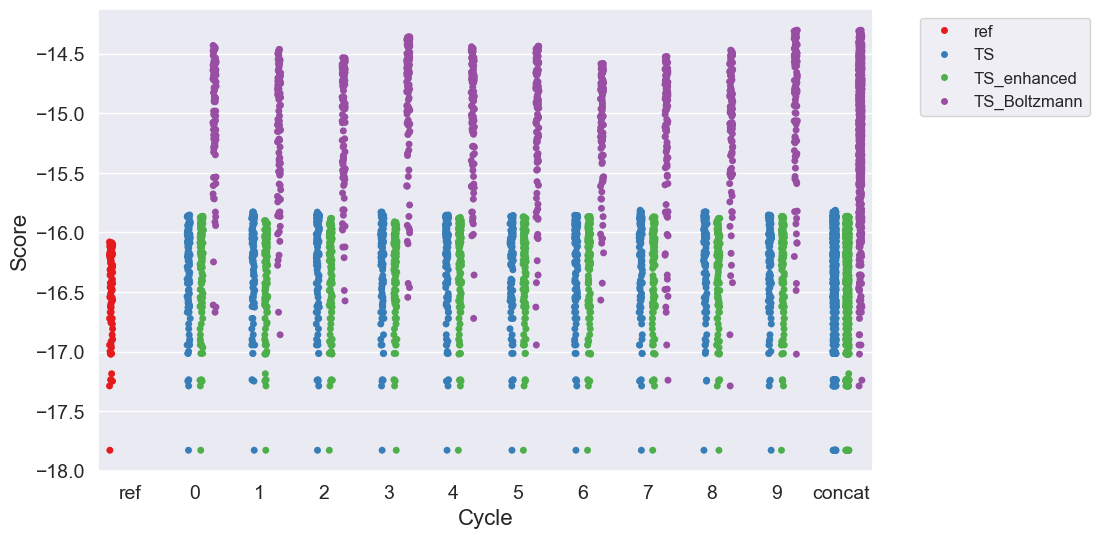

In [140]:
palette_colors = sns.color_palette("Set1")[:4]

# Set theme
sns.set_theme(style="darkgrid")

# Top subplot (stripplot) with concatenated results
plt.figure(figsize=(10, 6))
ax1 = sns.stripplot(data=all_results, x="cycle", y="score", hue="method", dodge=True, palette=palette_colors)
ax1.set_ylabel("Score", fontsize=16)
ax1.set_xlabel("Cycle", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Legend outside plot

### Generate Bar Plot with the counts of recovered actives

In [146]:
# Count matching products with reference for each method and cycle
reference_products = ref_df["Name"].unique()

# Get all unique cycles - reference first, then numbered cycles, then concat
numbered_cycles = sorted([c for c in all_results["cycle"].unique() if c not in ["concat", "ref"]])
all_cycles = ["ref"] + numbered_cycles + ["concat"]

# For all_results, handle concat separately
match_counts = []

for cycle in all_cycles:
    # Get only methods that exist for this cycle
    available_methods = all_results.filter(pl.col("cycle") == cycle)["method"].unique().to_list()
    
    for method in available_methods:
        subset = all_results.filter(
            (pl.col("cycle") == cycle) & (pl.col("method") == method)
        )
        
        # For concat cycle, use unique Names only
        if cycle == "concat":
            subset = subset.unique(subset=["Name"])
        
        match_count = subset.filter(pl.col("Name").is_in(reference_products)).height
        match_counts.append({"cycle": cycle, "method": method, "match_count": match_count})

match_counts_df = pl.DataFrame(match_counts)

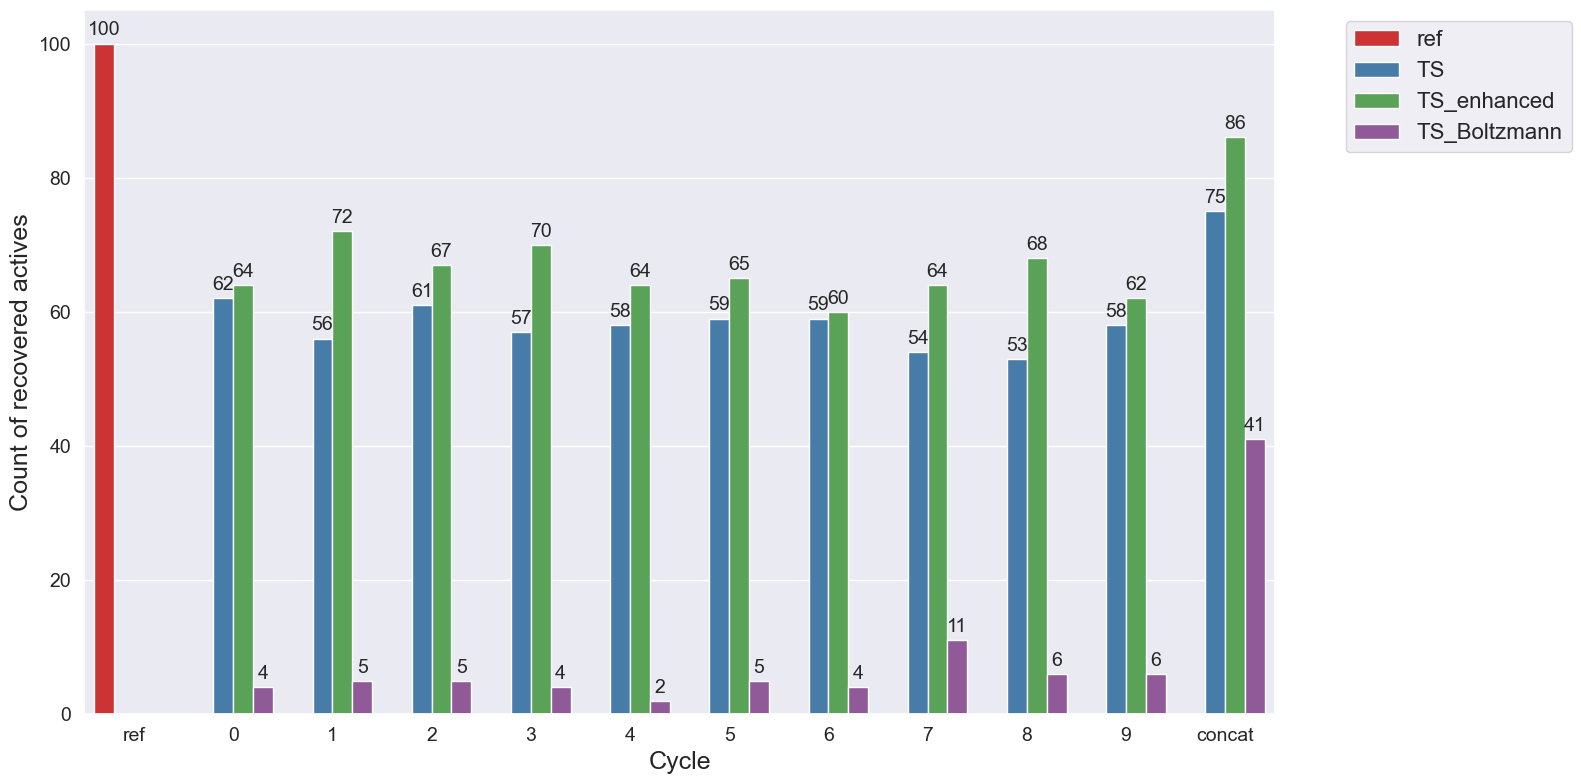

In [148]:
# Create grouped bar plot with seaborn
# Create grouped bar plot with seaborn
palette_colors = sns.color_palette("Set1")[:4]
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot(data=match_counts_df.to_pandas(), x="cycle", y="match_count", hue="method", 
            palette=palette_colors, ax=ax, order=all_cycles)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=14, padding=3)


ax.set_ylabel("Count of recovered actives", fontsize=18)
ax.set_xlabel("Cycle", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

plt.tight_layout()
plt.show()

### Generating Line Plot with Error Bars for Actives Recovered


In [149]:
all_results_all = pl.concat([
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(5000)
               for i, df in enumerate(ts_std_df_list)]).with_columns(pl.lit("TS").alias("method")),
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(5000)
               for i, df in enumerate(ts_enhanced_df_list)]).with_columns(pl.lit("TS_enhanced").alias("method")),
    pl.concat([df.with_columns(pl.lit(str(i)).alias("cycle")).drop("SMILES").sort("score", descending=False).head(5000)
               for i, df in enumerate(ts_boltzmann_df_list)]).with_columns(pl.lit("TS_Boltzmann").alias("method"))
])

In [154]:
top_ns = [10, 25, 50, 100, 200, 300, 400, 500]

# Initialize empty polars DataFrame with schema
top_ns_frac = pl.DataFrame(
    schema={
        "cycle": pl.String,
        "top_n": pl.Int64,
        "method": pl.String,
        "frac_top_n": pl.Float64
    }
)

In [180]:
# Build list of rows - one row per cycle, method, and top_n
rows = []

# Only use numbered cycles (not reference or concat)
numbered_cycles = sorted([c for c in all_results_all["cycle"].unique() if c not in ["concat", "reference"]])

# Get top-n reference products (sorted by score)
reference_sorted = ref_df.sort("score", descending=False)

for cycle in numbered_cycles:
    for method in ["TS", "TS_enhanced", "TS_Boltzmann"]:
        # Get top products from this method
        subset = all_results_all.filter(
            (pl.col("cycle") == cycle) & (pl.col("method") == method)
        ).sort("score", descending=False)
        
        for n in top_ns:
            # Get top-n from reference and method
            top_n_reference = reference_sorted.head(n)["Name"].to_list()
            top_n_method = subset.head(n)["Name"].to_list()
            
            # Count how many top-n REFERENCE products appear in method's top-n
            matches = len([p for p in top_n_reference if p in top_n_method])
            frac_top_n = matches / n  # Fraction of top-n reference recovered by method
            
            rows.append({
                "cycle": cycle,
                "top_n": n,
                "method": method,
                "frac_top_n": frac_top_n
            })

# Create DataFrame from all rows
top_ns_frac = pl.DataFrame(rows)

In [181]:
# Now group by top_n and method to get statistics ACROSS cycles
grouped_stats = top_ns_frac.group_by(['top_n', 'method']).agg([
    pl.col('frac_top_n').mean().alias('mean'),
    pl.col('frac_top_n').std().alias('std'),
    pl.col('frac_top_n').count().alias('count')
]).sort(['top_n', 'method'])

grouped_stats = grouped_stats.with_columns(pl.col('top_n').cast(pl.String))

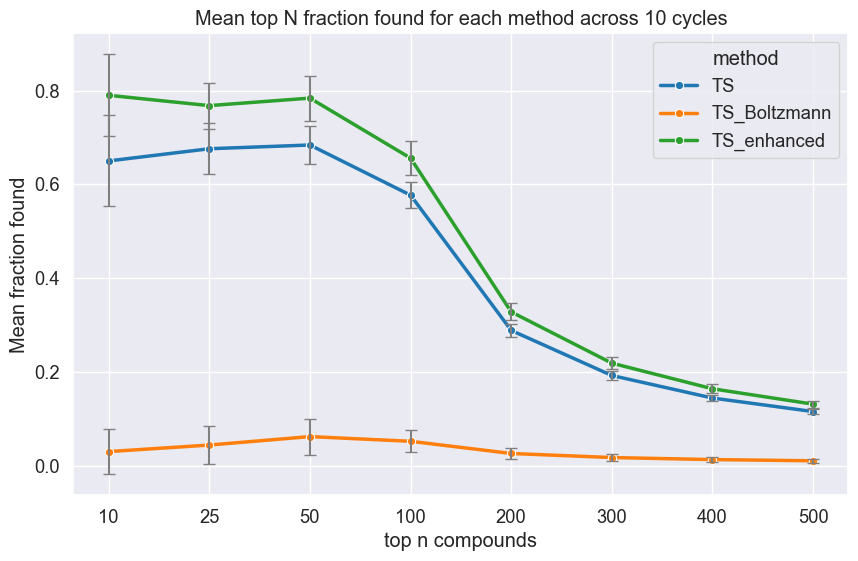

In [182]:
plt.figure(figsize=(10, 6)) # set the size of the plot
sns.set_theme(style="darkgrid", palette="tab10", font_scale=1.2)

# Ensure sub_category is sortable (e.g., categorical or ordered)
grouped_stats = grouped_stats.with_columns(pl.col('top_n').cast(pl.String))

# Line plot per category with error bars
sns.lineplot(
    data=grouped_stats,
    x='top_n',
    y='mean',
    hue='method',  # color line by category
    marker='o',
    errorbar=None,
    linewidth=2.5  # Disable built-in CI
)

# Add error bars manually using plt.errorbar
for row in grouped_stats.iter_rows(named=True):
    if pd.notnull(row['std']):
        plt.errorbar(
            x=row['top_n'],
            y=row['mean'],
            yerr=row['std'],
            fmt='none',
            capsize=4,
            ecolor='gray'
        )

plt.title("Mean top N fraction found for each method across 10 cycles")
plt.xlabel("top n compounds")
plt.ylabel("Mean fraction found")
plt.show()